Let's start here! If you can directly link to an image relevant to your notebook, such as [canonical logos](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg), do so here at the top of your notebook. You can do this with Markdown syntax,

> `![<image title>](http://link.com/to/image.png "image alt text")`

or edit this cell to see raw HTML `img` demonstration. This is preferred if you need to shrink your embedded image. **Either way be sure to include `alt` text for any embedded images to make your content more accessible.**

<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# Crash Course Towards Your First Model

Next, title your notebook appropriately with a top-level Markdown header, `#`. Do not use this level header anywhere else in the notebook. Our book build process will use this title in the navbar, table of contents, etc. Keep it short, keep it descriptive. Follow this with a `---` cell to visually distinguish the transition to the prerequisites section.

---

## Overview
If you have an introductory paragraph, lead with it here! Keep it short and tied to your material, then be sure to continue into the required list of topics below,

1. This is a numbered list of the specific topics
1. These should map approximately to your main sections of content
1. Or each second-level, `##`, header in your notebook
1. Keep the size and scope of your notebook in check
1. And be sure to let the reader know up front the important concepts they'll be leaving with

## Prerequisites
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app) Jupyter Book.

Following your overview, tell your reader what concepts, packages, or other background information they'll **need** before learning your material. Tie this explicitly with links to other pages here in Foundations or to relevant external resources. Remove this body text, then populate the Markdown table, denoted in this cell with `|` vertical brackets, below, and fill out the information following. In this table, lay out prerequisite concepts by explicitly linking to other Foundations material or external resources, or describe generally helpful concepts.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports

Here we'll be using a basic set of Python libraries, along with Numba for fast numerical routines. A helpful constants file is also imported.

In [1]:
import numpy as np
import numba
import xarray as xr
import matplotlib.pyplot as plt

from constants import *
from driver import ModelDriver

## Introduction

...TODO...

In [2]:
# some subsection code
new = "helpful information"

## Basic Equations

...TODO...

### Starting Equations

...TODO...

### Assumptions and Simplification

...TODO...

### Final Prognostic Equations

...TODO...

## Model Configuration

...TODO...

### Grid Type

...TODO...

### Initial/Boundary Conditions

...TODO...

## Discritization

...TODO...

In [3]:
@numba.njit()
def u_tendency_u_advection_term(u, dx):
    term = np.zeros_like(u)
    for k in range(1, u.shape[0] - 1):
        for i in range(1, u.shape[1] - 1):
            term[k, i] = u[k, i] * (u[k, i + 1] - u[k, i - 1]) / (2 * dx)
    return term

In [4]:
@numba.njit()
def u_tendency_w_advection_term(u, w, dz):
    term = np.zeros_like(u)
    for k in range(1, u.shape[0] - 1):
        for i in range(1, u.shape[1] - 1):
            term[k, i] = 0.25 * (
                w[k + 1, i] + w[k + 1, i - 1] + w[k, i] + w[k, i - 1] 
            ) * (u[k + 1, i] - u[k - 1, i]) / (2 * dz)
    return term

In [5]:
@numba.njit()
def u_tendency_pgf_term(u, pi, theta_base, dx):
    term = np.zeros_like(u)
    for k in range(1, u.shape[0] - 1):
        for i in range(1, u.shape[1] - 1):
            term[k, i] = c_p * theta_base[k] * (pi[k, i] - pi[k, i - 1]) / dx
    return term

In [6]:
@numba.njit()
def u_tendency(u, w, pi, theta_base, dx, dz):
    return (
        u_tendency_u_advection_term(u, dx)
        + u_tendency_w_advection_term(u, w, dz)
        + u_tendency_pgf_term(u, pi, theta_base, dx)
    ) * -1

In [7]:
@numba.njit()
def w_tendency_u_advection_term(u, w, dx):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = 0.25 * (
                u[k, i] + u[k, i + 1] + u[k - 1, i] + u[k - 1, i + 1]  
            ) * (w[k, i + 1] - w[k, i - 1]) / (2 * dx)
    return term

In [8]:
@numba.njit()
def w_tendency_w_advection_term(w, dz):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = w[k, i] * (w[k + 1, i] - w[k - 1, i]) / (2 * dz)
    return term

In [9]:
@numba.njit()
def w_tendency_pgf_term(w, pi, theta_base, dz):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = c_p * 0.5 * (theta_base[k] + theta_base[k - 1]) * (pi[k - 1, i] - pi[k, i]) / dz
    return term

In [10]:
@numba.njit()
def w_tendency_buoyancy_term(w, theta_p, theta_base):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = gravity * (theta_p[k, i] + theta_p[k - 1, i]) / (theta_base[k] + theta_base[k - 1]) 
    return term

In [11]:
@numba.njit()
def w_tendency(u, w, pi, theta_p, theta_base, dx, dz):
    return (
        w_tendency_u_advection_term(u, w, dx) * -1.0
        - w_tendency_w_advection_term(w, dz)
        - w_tendency_pgf_term(w, pi, theta_base, dz)
        + w_tendency_buoyancy_term(w, theta_p, theta_base)
    )

In [12]:
@numba.njit()
def theta_p_tendency_u_advection_term(u, theta_p, dx):
    term = np.zeros_like(theta_p)
    for k in range(1, theta_p.shape[0] - 1):
        for i in range(1, theta_p.shape[1] - 1):
            term[k, i] = (
                (u[k, i + 1] + u[k, i]) / 2
                * (theta_p[k, i + 1] - theta_p[k, i - 1]) / (2 * dx)
            )
    return term

In [13]:
@numba.njit()
def theta_p_tendency_w_advection_of_perturbation_term(w, theta_p, dz):
    term = np.zeros_like(theta_p)
    for k in range(1, theta_p.shape[0] - 1):
        for i in range(1, theta_p.shape[1] - 1):
            term[k, i] = (
                (w[k + 1, i] + w[k, i]) / 2
                * (theta_p[k + 1, i] - theta_p[k - 1, i]) / (2 * dz)
            )
    return term

In [14]:
@numba.njit()
def theta_p_tendency_w_advection_of_base_term(w, theta_p, theta_base, dz):
    term = np.zeros_like(theta_p)
    for k in range(1, theta_p.shape[0] - 1):
        for i in range(1, theta_p.shape[1] - 1):
            term[k, i] = (
                (w[k + 1, i] + w[k, i]) / 2
                * (theta_base[k + 1] - theta_base[k - 1]) / (2 * dz)
            )
    return term

In [15]:
@numba.njit()
def theta_p_tendency(u, w, theta_p, theta_base, dx, dz):
    return (
        theta_p_tendency_u_advection_term(u, theta_p, dx)
        + theta_p_tendency_w_advection_of_perturbation_term(w, theta_p, dz)
        + theta_p_tendency_w_advection_of_base_term(w, theta_p, theta_base, dz)
    ) * -1

In [16]:
@numba.njit()
def pi_tendency(u, w, pi, theta_base, rho_base, c_s_sqr, dx, dz):
    term = np.zeros_like(pi)
    for k in range(1, pi.shape[0] - 1):
        for i in range(1, pi.shape[1] - 1):
            term[k, i] = (
                -1 * (c_s_sqr / (c_p * rho_base[k] * theta_base[k]**2))
                * (
                    (rho_base[k] * theta_base[k] * (u[k, i + 1] - u[k, i]) / dx)
                    + (
                        (w[k + 1, i] + w[k, i]) / 2
                        * (rho_base[k + 1] * theta_base[k + 1] - rho_base[k - 1] * theta_base[k - 1]) / (2 * dz)
                    )
                    + (rho_base[k] * theta_base[k] * (w[k + 1, i] - w[k, i]) / dz)
                )
            )
    return term

In [17]:
# Set up model
model = ModelDriver(
    nx=160, nz=100, dx=200., dz=200., dt=0.01, c_s_sqr=50.0**2,
    u_tendency=u_tendency, w_tendency=w_tendency, theta_p_tendency=theta_p_tendency, pi_tendency=pi_tendency
)
model.initialize_isentropic_base_state(300., 9.5e4)
model.initialize_warm_bubble(3.0, 4.0e3, 4.0e3, 2.0e3)

# Start saving results
results = []
results.append(model.current_state())

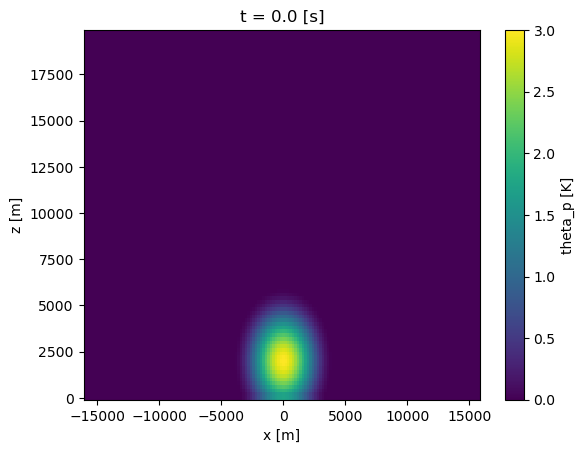

In [18]:
results[0]['theta_p'][0].plot()

In [19]:
# Integrate the model, saving after desired timestep counts
model.take_first_timestep()
results.append(model.current_state())

In [20]:
for _ in range(3000):
    model.integrate(1)
    results.append(model.current_state())

# Merge results
ds = xr.concat(results, 't')

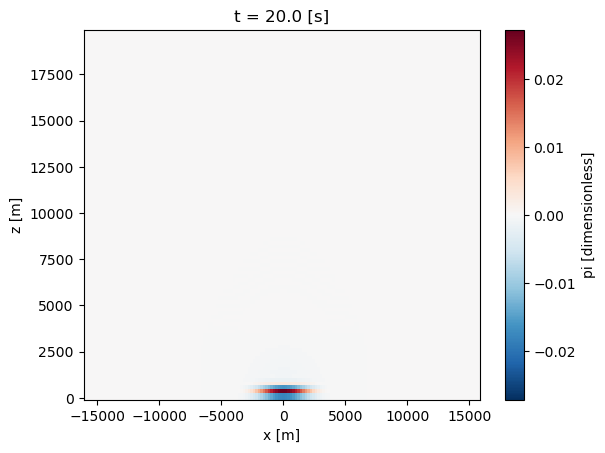

In [40]:
ds['pi'][2000].plot.imshow()

---

## Summary

...TODO...

Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!